In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_19.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_0.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_7.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_4.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_8.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_9.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_6.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_3.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_13.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_1.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_5.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_12.png
/kaggle/input/wheat-plant-diseases/da

In [2]:
# 导入必要的库
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

# 设置随机种子，保证实验可复现
torch.manual_seed(42)
np.random.seed(42)

# 检查是否有可用的CUDA（GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

使用设备: cuda


In [3]:
# 定义自定义数据集类
class WheatDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # 获取所有类别名称
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}  # 类别名称到索引的映射
        
        self.images = []
        self.labels = []
        
        # 加载所有图片路径和对应标签
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # 加载并转换图片
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [4]:
# 定义数据增强和预处理
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图片大小
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(10),  # 随机旋转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 颜色抖动
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载训练集和验证集
train_dataset = WheatDiseaseDataset(root_dir="/kaggle/input/wheat-plant-diseases/data/train", transform=train_transform)
val_dataset = WheatDiseaseDataset(root_dir="/kaggle/input/wheat-plant-diseases/data/valid", transform=val_transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# 打印数据集信息
print(f'训练集样本数: {len(train_dataset)}')
print(f'验证集样本数: {len(val_dataset)}')
print(f'类别数: {len(train_dataset.classes)}')
print('类别名称:', train_dataset.classes)

训练集样本数: 13104
验证集样本数: 300
类别数: 15
类别名称: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']


In [5]:
# 定义 EfficientNetB0 模型
class EfficientNetB0Model(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB0Model, self).__init__()
        # 加载预训练的 EfficientNetB0 模型
        self.model = models.efficientnet_b0(pretrained=True)
        # 替换最后的分类层
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),  # 添加 Dropout 防止过拟合
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# 初始化模型
model = EfficientNetB0Model(num_classes=len(train_dataset.classes))
model = model.to(device)  # 将模型移到 GPU（如果可用）

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # AdamW 优化器
# 学习率调度器，当验证损失不再下降时降低学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# 打印模型信息
print(f'模型类别数: {len(train_dataset.classes)}')
print(f'类别名称: {train_dataset.classes}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 128MB/s] 


模型类别数: 15
类别名称: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
# 定义训练函数
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()  # 设置为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # 清空梯度
        outputs = model(images)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

# 定义验证函数
def validate(model, loader, criterion, device):
    model.eval()  # 设置为评估模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # 不计算梯度
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

In [7]:
# 设置训练参数
num_epochs = 30
best_val_loss = float('inf')
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# 训练循环
for epoch in range(num_epochs):
    # 训练一个 epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # 验证
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # 更新学习率
    scheduler.step(val_loss)
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    # 打印训练信息
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.2f}%')
    print(f'验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.2f}%')
    print('-' * 50)

Epoch 1/30:
训练损失: 0.9709, 训练准确率: 69.22%
验证损失: 1.6162, 验证准确率: 72.67%
--------------------------------------------------
Epoch 2/30:
训练损失: 0.6263, 训练准确率: 79.50%
验证损失: 1.6141, 验证准确率: 72.00%
--------------------------------------------------
Epoch 3/30:
训练损失: 0.4975, 训练准确率: 83.18%
验证损失: 1.0062, 验证准确率: 78.67%
--------------------------------------------------
Epoch 4/30:
训练损失: 0.4483, 训练准确率: 84.18%
验证损失: 0.7563, 验证准确率: 82.33%
--------------------------------------------------
Epoch 5/30:
训练损失: 0.3867, 训练准确率: 86.68%
验证损失: 0.6892, 验证准确率: 83.00%
--------------------------------------------------
Epoch 6/30:
训练损失: 0.3567, 训练准确率: 87.64%
验证损失: 1.6458, 验证准确率: 86.33%
--------------------------------------------------
Epoch 7/30:
训练损失: 0.3417, 训练准确率: 87.87%
验证损失: 0.9598, 验证准确率: 88.00%
--------------------------------------------------
Epoch 8/30:
训练损失: 0.2960, 训练准确率: 89.22%
验证损失: 1.5628, 验证准确率: 84.00%
--------------------------------------------------
Epoch 9/30:
训练损失: 0.2851, 训练准确率: 89.85%
验证损失: 0.

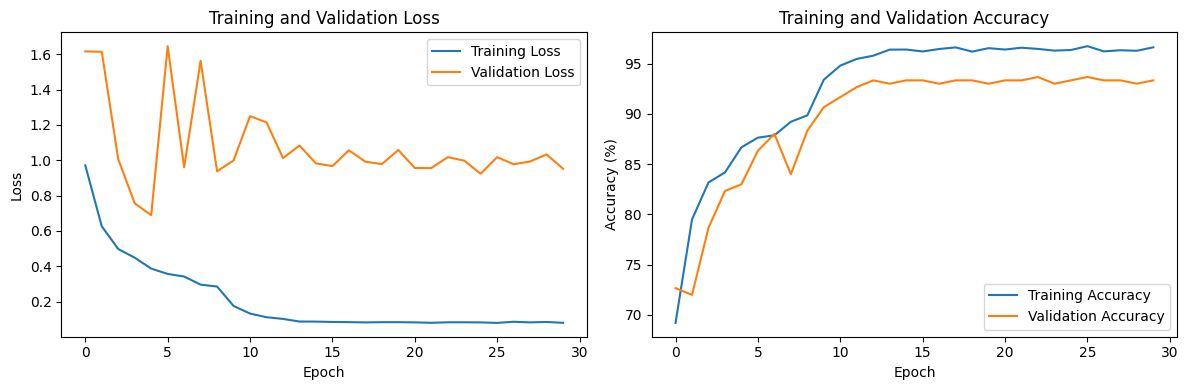

In [8]:
# 绘制训练历史
plt.figure(figsize=(12, 4))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

Classification Report:
                      precision    recall  f1-score   support

               Aphid       0.93      0.70      0.80        20
          Black Rust       0.91      1.00      0.95        20
               Blast       0.86      0.90      0.88        20
          Brown Rust       0.95      0.95      0.95        20
     Common Root Rot       0.83      1.00      0.91        20
Fusarium Head Blight       0.94      0.85      0.89        20
             Healthy       1.00      0.10      0.18        20
         Leaf Blight       0.73      0.80      0.76        20
              Mildew       0.95      1.00      0.98        20
                Mite       0.81      0.65      0.72        20
            Septoria       1.00      0.95      0.97        20
                Smut       0.95      0.95      0.95        20
            Stem fly       0.94      0.85      0.89        20
            Tan spot       0.62      0.80      0.70        20
         Yellow Rust       0.53      0.95     

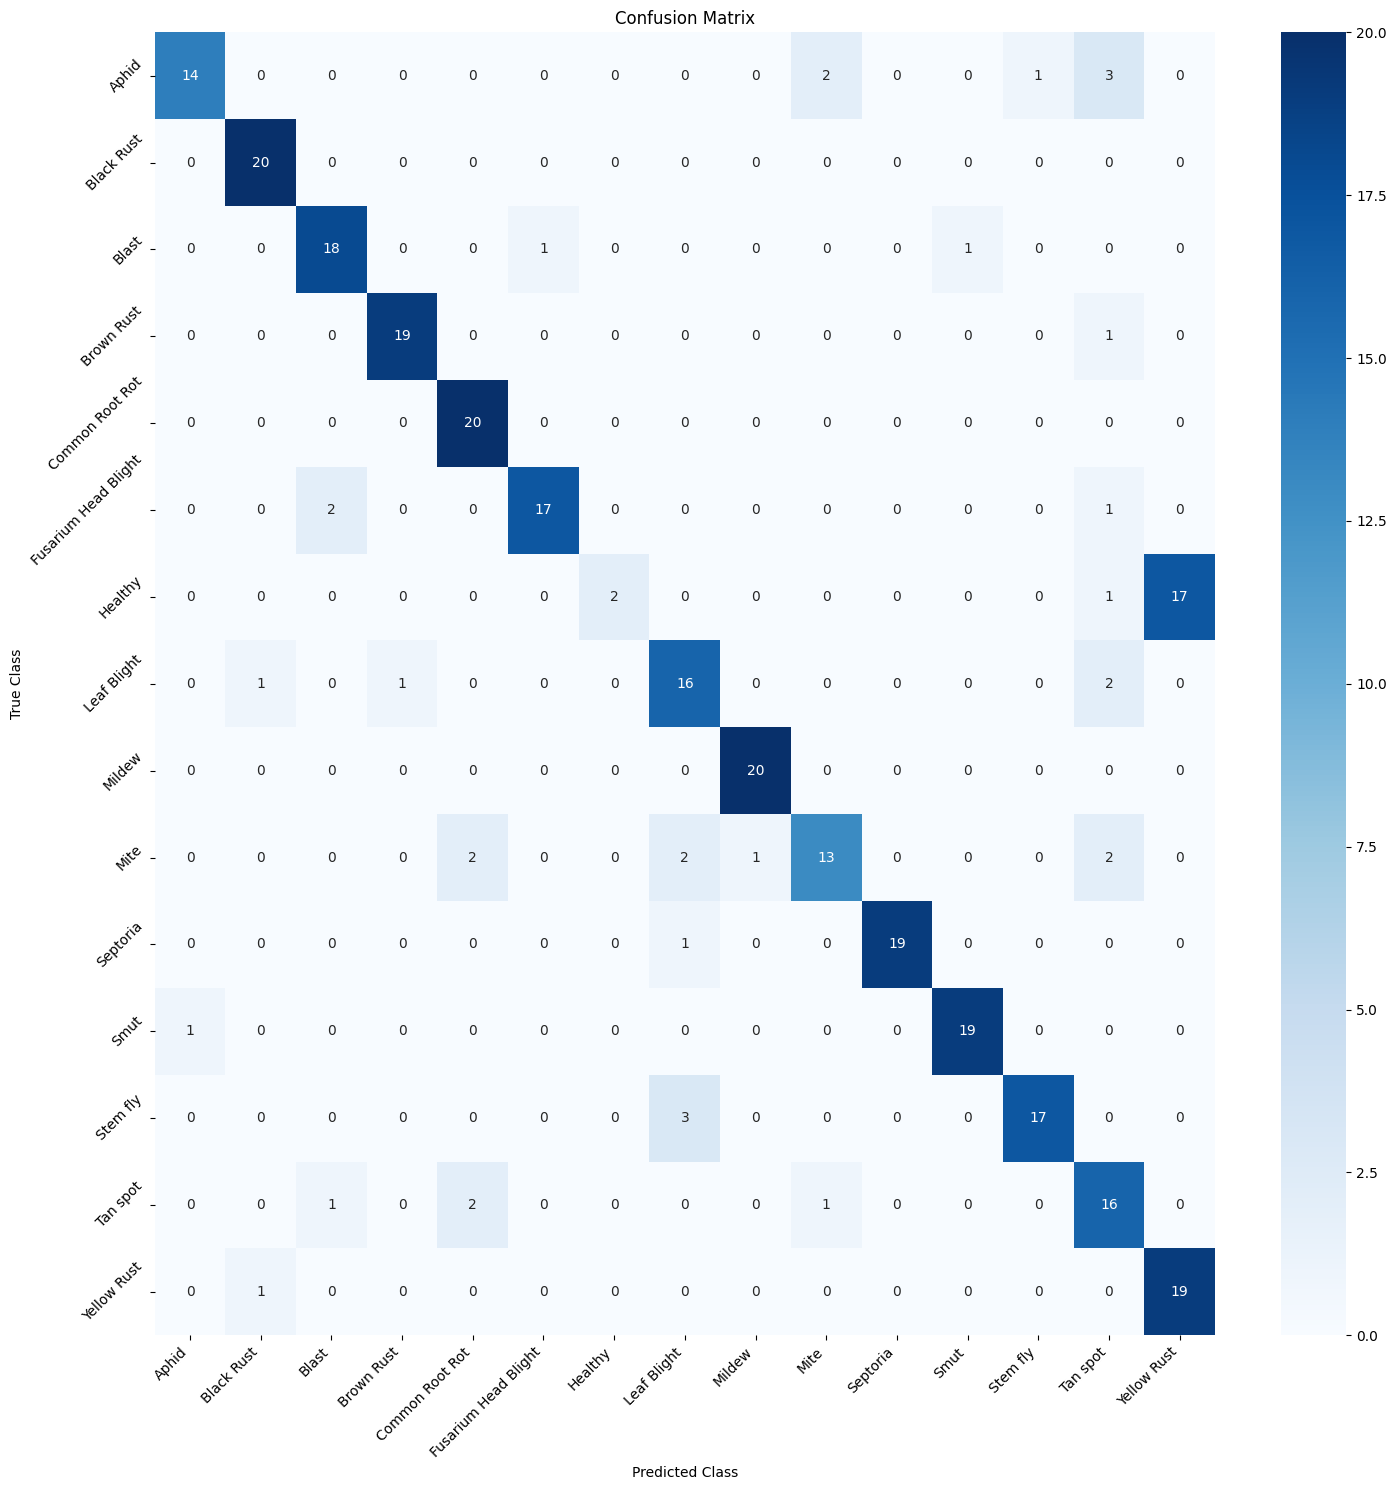

In [9]:
# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 获取验证集的预测结果
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 打印分类报告
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# 绘制混淆矩阵
plt.figure(figsize=(15, 15))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()